In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
#!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data_to_fit_suppliment_v4.csv')

In [4]:
data_counts = data['Market'].value_counts()
data_counts

Market
China             1003
United States      895
India              713
United Kingdom     648
Japan              503
Canada             419
Hong Kong          376
Malaysia           361
Sweden             322
Germany            293
France             196
Thailand           191
Taiwan             187
Switzerland        178
Korea              175
Brazil             129
Italy              128
Turkey             117
South Africa       114
Mexico              99
Norway              93
Singapore           92
Indonesia           88
Finland             73
Spain               72
Denmark             64
Netherlands         58
New Zealand         58
Argentina           56
Morocco             50
Belgium             49
Chile               46
Poland              42
Egypt               35
Peru                34
Austria             32
Vitnam              26
Greece              25
Colombia            21
Portugal            16
Ireland             14
Iceland              8
Hungary              7
Nige

# 1.亚洲

## 1.1 东亚

### 1.1.1 预测日本

In [3]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

In [4]:
data_counts = data['Market'].value_counts()
data_counts

Market
China             1003
United States      895
India              713
United Kingdom     648
Japan              503
Canada             419
Hong Kong          376
Malaysia           361
Sweden             322
Germany            293
France             196
Thailand           191
Taiwan             187
Switzerland        177
Korea              175
Brazil             129
Italy              128
Turkey             117
South Africa       114
Mexico              99
Norway              93
Singapore           92
Indonesia           88
Finland             73
Spain               72
Denmark             64
Netherlands         58
New Zealand         58
Argentina           56
Morocco             50
Belgium             49
Chile               46
Egypt               35
Peru                34
Austria             32
Vitnam              26
Greece              25
Colombia            21
Portugal            16
Ireland             14
Iceland              8
Hungary              7
Nigeria              7
Ugan

In [5]:
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong', 'Korea','Taiwan'])]
test_data = data[data['Market'] == 'Japan']


In [6]:
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 Hong Kong     376
 Taiwan        187
 Korea         175
 Name: count, dtype: int64,
 Market
 Japan    503
 Name: count, dtype: int64)

In [7]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

In [8]:
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [9]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7765651924181505 F1 Score: 0.7743354098510514 AUC: 0.9390352236021912 prAUC: 0.8355330983810627
Test Results: Accuracy: 0.6441351888667992 F1 Score: 0.6166157926388034 AUC: 0.8862155532998839 prAUC: 0.687190016068801


In [10]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,         # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7805858701895463 F1 Score: 0.7783507564856473 AUC: 0.9419774086306854 prAUC: 0.8444556843978441
Test Results: Accuracy: 0.6600397614314115 F1 Score: 0.6371721052040435 AUC: 0.8837912593187962 prAUC: 0.6847897024524358


In [12]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7415278575531303 F1 Score: 0.7320516148784884 AUC: 0.9228543332795068 prAUC: 0.791189908771599
Test Results: Accuracy: 0.6282306163021869 F1 Score: 0.5963098517363495 AUC: 0.8762746726875731 prAUC: 0.6742595105712688


In [32]:

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=20, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 1000, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 3, 'alpha': 3}

Train Results: Accuracy: 0.7514749262536873 F1 Score: 0.7429220300911722 AUC: 0.9274855131177002 prAUC: 0.802125777026916
Test Results: Accuracy: 0.674975074775673 F1 Score: 0.6653678567383301 AUC: 0.8725454907371957 prAUC: 0.6306463452685168


#### （1）亚洲国家数据——日本

In [13]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong', 'Korea','Singapore','Thailand','Malaysia','Indonesia','India','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'Japan']

In [14]:
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 India         713
 Hong Kong     376
 Malaysia      361
 Thailand      191
 Taiwan        187
 Korea         175
 Singapore      92
 Indonesia      88
 Vitnam         26
 Name: count, dtype: int64,
 Market
 Japan    503
 Name: count, dtype: int64)

In [15]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

In [16]:
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [17]:
# baseline参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7680572851805728 F1 Score: 0.7644755355030138 AUC: 0.9350176229326664 prAUC: 0.8228049347313708
Test Results: Accuracy: 0.6938369781312127 F1 Score: 0.6809427380571786 AUC: 0.8889602576068409 prAUC: 0.6915014880356808


In [18]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma=1,                   # 添加 gamma 限制分裂
    max_depth=15,               # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.2,         # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8303237858032378 F1 Score: 0.8279080337516853 AUC: 0.9646359985678457 prAUC: 0.8998735005824507
Test Results: Accuracy: 0.6898608349900597 F1 Score: 0.6766028944419447 AUC: 0.8816471131062057 prAUC: 0.6716482797025415


In [19]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7861145703611457 F1 Score: 0.7827335086058671 AUC: 0.9437121079213397 prAUC: 0.8462173017507257
Test Results: Accuracy: 0.68389662027833 F1 Score: 0.6668610817184807 AUC: 0.886906112047773 prAUC: 0.684663887417694


### 1.1.2 预测中国

#### （1） 亚洲数据

In [20]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Hong Kong', 'Korea','Singapore','Thailand','Malaysia','Indonesia','India','Japan','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'China']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Japan        503
 Hong Kong    376
 Malaysia     361
 Thailand     191
 Taiwan       187
 Korea        175
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 China    1003
 Name: count, dtype: int64)

In [21]:
# 分离训练集的特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']

# 分离测试集（中国数据）的特征和标签
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [22]:
# baseline参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7699115044247787 F1 Score: 0.7635740536564029 AUC: 0.9405242070590425 prAUC: 0.8372385407225457
Test Results: Accuracy: 0.6769690927218345 F1 Score: 0.6690676285837637 AUC: 0.8717953222829423 prAUC: 0.6295766369846008


In [29]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=5,                # 降低树的深度
    n_estimators=1200,
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7654867256637168 F1 Score: 0.759194222579412 AUC: 0.9367676442638221 prAUC: 0.8281312262532433
Test Results: Accuracy: 0.674975074775673 F1 Score: 0.6687169019355853 AUC: 0.8725435247994663 prAUC: 0.6344478758563544


In [30]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 3, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7474188790560472 F1 Score: 0.7379268006412388 AUC: 0.9257040923768425 prAUC: 0.7971829639356972
Test Results: Accuracy: 0.6739780658025922 F1 Score: 0.6643116103617408 AUC: 0.8710227700033611 prAUC: 0.6275443354712108


#### （2） 日韩数据

In [33]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Hong Kong', 'Korea','Japan','Taiwan'])]
test_data = data[data['Market'] == 'China']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Japan        503
 Hong Kong    376
 Taiwan       187
 Korea        175
 Name: count, dtype: int64,
 Market
 China    1003
 Name: count, dtype: int64)

In [34]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

In [35]:

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [39]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7880741337630943 F1 Score: 0.7807976198440029 AUC: 0.9477852258252707 prAUC: 0.87108152169596
Test Results: Accuracy: 0.6360917248255235 F1 Score: 0.6244525203908146 AUC: 0.861135004137813 prAUC: 0.6189723979815694


In [44]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth = 15,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8106365834004835 F1 Score: 0.80516979710577 AUC: 0.9543222561635295 prAUC: 0.8867269774439932
Test Results: Accuracy: 0.6420737786640079 F1 Score: 0.6302392423285341 AUC: 0.859392793595817 prAUC: 0.6191317803220784


In [45]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.01, 'lambda': 2, 'alpha': 2}

Train Results: Accuracy: 0.7622884770346495 F1 Score: 0.7492911083740057 AUC: 0.9353574079950734 prAUC: 0.8388078707960644
Test Results: Accuracy: 0.6331006979062812 F1 Score: 0.6206004501612753 AUC: 0.8601052404155245 prAUC: 0.6173579026266907


In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9464704583099741, 'gamma': 3, 'learning_rate': 0.08143340896097039, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 508, 'reg_alpha': 2, 'reg_lambda': 8, 'subsample': 0.9162213204002109}

Train Results: Accuracy: 0.7365028203062046 F1 Score: 0.7211109299530518 AUC: 0.9192034898264664 prAUC: 0.800955966490674
Test Results: Accuracy: 0.6161515453639083 F1 Score: 0.6023243939792665 AUC: 0.8571881405850896 prAUC: 0.6059847255220161


### 1.1.3 预测韩国

#### （1） 中日数据

In [51]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong','Japan','Taiwan'])]
test_data = data[data['Market'] == 'Korea']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 Japan         503
 Hong Kong     376
 Taiwan        187
 Name: count, dtype: int64,
 Market
 Korea    175
 Name: count, dtype: int64)

In [52]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [53]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7728371193813437 F1 Score: 0.768224910610465 AUC: 0.9414193052267339 prAUC: 0.8267803248430423
Test Results: Accuracy: 0.5885714285714285 F1 Score: 0.5948813371192835 AUC: 0.8625512639802428 prAUC: 0.7032934504489976


In [54]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8980183663605606 F1 Score: 0.8970833517279744 AUC: 0.9861799648356213 prAUC: 0.9556771440514509
Test Results: Accuracy: 0.64 F1 Score: 0.627137674847172 AUC: 0.8595338034578087 prAUC: 0.6934162532969315


In [55]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.01, 'lambda': 1, 'alpha': 3}

Train Results: Accuracy: 0.749637506041566 F1 Score: 0.7416826167849597 AUC: 0.924411743026492 prAUC: 0.7819237736539765
Test Results: Accuracy: 0.6057142857142858 F1 Score: 0.6103109461966605 AUC: 0.8480026939163187 prAUC: 0.6884654058553077


In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.6746074041599417, 'gamma': 4, 'learning_rate': 0.43917940240685993, 'max_depth': 15, 'min_child_weight': 4, 'n_estimators': 602, 'reg_alpha': 2, 'reg_lambda': 3, 'subsample': 0.9047505230698577}

Train Results: Accuracy: 0.7220879652005799 F1 Score: 0.7125043936603613 AUC: 0.9101570902027658 prAUC: 0.7429452211357633
Test Results: Accuracy: 0.5885714285714285 F1 Score: 0.5848839770793481 AUC: 0.8395439338643753 prAUC: 0.6790936683412457


#### (2) 亚洲数据

In [59]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong', 'Singapore','Thailand','Malaysia','Indonesia','India','Japan','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'Korea']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 India         713
 Japan         503
 Hong Kong     376
 Malaysia      361
 Thailand      191
 Taiwan        187
 Singapore      92
 Indonesia      88
 Vitnam         26
 Name: count, dtype: int64,
 Market
 Korea    175
 Name: count, dtype: int64)

In [60]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [61]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators = 300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.765819209039548 F1 Score: 0.7605016225844703 AUC: 0.9354022421266377 prAUC: 0.812198358135477
Test Results: Accuracy: 0.6514285714285715 F1 Score: 0.6417106918238993 AUC: 0.876484082423125 prAUC: 0.7208077106306541


In [62]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 3, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7516949152542373 F1 Score: 0.7447848628652909 AUC: 0.9249686408070226 prAUC: 0.7808705630384559
Test Results: Accuracy: 0.6457142857142857 F1 Score: 0.6362069946928731 AUC: 0.8761846166763458 prAUC: 0.7250677168136275


In [63]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.05, 'lambda': 3, 'alpha': 3}

Train Results: Accuracy: 0.7516949152542373 F1 Score: 0.7447848628652909 AUC: 0.9249686408070226 prAUC: 0.7808705630384559
Test Results: Accuracy: 0.6457142857142857 F1 Score: 0.6362069946928731 AUC: 0.8761846166763458 prAUC: 0.7250677168136275


In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7083329005048297, 'gamma': 3, 'learning_rate': 0.3820213214995577, 'max_depth': 14, 'min_child_weight': 5, 'n_estimators': 673, 'reg_alpha': 5, 'reg_lambda': 7, 'subsample': 0.7141572374700539}

Train Results: Accuracy: 0.7231638418079096 F1 Score: 0.7132487941106239 AUC: 0.9064928742714966 prAUC: 0.7293759387609917
Test Results: Accuracy: 0.6457142857142857 F1 Score: 0.6359486256414942 AUC: 0.8684564280326612 prAUC: 0.708178446997505


In [69]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=20,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8200564971751413 F1 Score: 0.8167849560052086 AUC: 0.9606119597772999 prAUC: 0.8818639576240077
Test Results: Accuracy: 0.6342857142857142 F1 Score: 0.6403140307796792 AUC: 0.8741135762642314 prAUC: 0.717027843247122


### 1.1.4 预测香港

In [71]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Japan','Korea','Taiwan'])]
test_data = data[data['Market'] == 'Hong Kong']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China     1003
 Japan      503
 Taiwan     187
 Korea      175
 Name: count, dtype: int64,
 Market
 Hong Kong    376
 Name: count, dtype: int64)

In [72]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [73]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.784796573875803 F1 Score: 0.7810111786778418 AUC: 0.9469555705147171 prAUC: 0.8496795817213597
Test Results: Accuracy: 0.6223404255319149 F1 Score: 0.6221101748817315 AUC: 0.8373417207713327 prAUC: 0.5787030131713479


In [74]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8993576017130621 F1 Score: 0.8984952187909119 AUC: 0.987822487532249 prAUC: 0.9635951252748329
Test Results: Accuracy: 0.6090425531914894 F1 Score: 0.606956032012047 AUC: 0.837090960366187 prAUC: 0.5640115872223681


In [75]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 3, 'lambda': 3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7392933618843683 F1 Score: 0.7269473459036225 AUC: 0.9194704067287838 prAUC: 0.7788697080826386
Test Results: Accuracy: 0.6329787234042553 F1 Score: 0.6238909093927825 AUC: 0.839129988453431 prAUC: 0.5759520628986181


In [76]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.01, 'lambda': 1, 'alpha': 3}

Train Results: Accuracy: 0.7612419700214133 F1 Score: 0.7543037472588823 AUC: 0.929002197715873 prAUC: 0.8028069520478158
Test Results: Accuracy: 0.6356382978723404 F1 Score: 0.6317150428092677 AUC: 0.8396392435233619 prAUC: 0.5750850218707432


In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=8
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7083329005048297, 'gamma': 3, 'learning_rate': 0.3820213214995577, 'max_depth': 14, 'min_child_weight': 5, 'n_estimators': 673, 'reg_alpha': 5, 'reg_lambda': 7, 'subsample': 0.7141572374700539}

Train Results: Accuracy: 0.7232334047109208 F1 Score: 0.7135765602629427 AUC: 0.9088265437737275 prAUC: 0.7477452869388824
Test Results: Accuracy: 0.6143617021276596 F1 Score: 0.614007941740623 AUC: 0.8314280898854316 prAUC: 0.5873389413415121


#### （1）亚洲数据

In [ ]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China','Korea' 'Singapore','Thailand','Malaysia','Indonesia','India','Japan','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'Hong Kong']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

### 1.1.5 预测台湾

In [79]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong','Japan','Korea'])]
test_data = data[data['Market'] == 'Taiwan']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 Japan         503
 Hong Kong     376
 Korea         175
 Name: count, dtype: int64,
 Market
 Taiwan    187
 Name: count, dtype: int64)

In [80]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [81]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7865824015556636 F1 Score: 0.7833720822505205 AUC: 0.9436788915491725 prAUC: 0.8405572866630189
Test Results: Accuracy: 0.6417112299465241 F1 Score: 0.5842649525031419 AUC: 0.8207244049580616 prAUC: 0.6802169898498136


In [83]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8235294117647058 F1 Score: 0.8207306494479697 AUC: 0.9616896294705015 prAUC: 0.8868174995910462
Test Results: Accuracy: 0.6577540106951871 F1 Score: 0.6221520514661356 AUC: 0.8083219031076483 prAUC: 0.6619373085159287


In [85]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits


Best Parameters: {'alpha': 3, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000}

Train Results: Accuracy: 0.7472046669907633 F1 Score: 0.7399164021200122 AUC: 0.924592096511007 prAUC: 0.7885030615662856
Test Results: Accuracy: 0.6577540106951871 F1 Score: 0.59368375401769 AUC: 0.8088601004127141 prAUC: 0.6822091665844443


In [86]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.01, 'lambda': 1, 'alpha': 3}

Train Results: Accuracy: 0.7476908118619349 F1 Score: 0.7404928908980921 AUC: 0.9254778056107479 prAUC: 0.7909057590135466
Test Results: Accuracy: 0.6577540106951871 F1 Score: 0.59368375401769 AUC: 0.8092422712549072 prAUC: 0.6807707136623831


In [87]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8034282764658811, 'gamma': 4, 'learning_rate': 0.13464611457443748, 'max_depth': 15, 'min_child_weight': 4, 'n_estimators': 724, 'reg_alpha': 7, 'reg_lambda': 3, 'subsample': 0.5806106436270022}

Train Results: Accuracy: 0.7000486144871172 F1 Score: 0.6873808406773761 AUC: 0.8936120590099371 prAUC: 0.7062420145038394
Test Results: Accuracy: 0.6631016042780749 F1 Score: 0.5793633701611413 AUC: 0.7887413216920754 prAUC: 0.6544525457652619


## 1.2 东南亚

### 1.2.1 预测印尼

In [29]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['India','Vitnam','Singapore','Thailand','Malaysia'])]
test_data = data[data['Market'] == 'Indonesia']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Thailand     191
 Singapore     92
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Indonesia    88
 Name: count, dtype: int64)

In [30]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [93]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7888647866955893 F1 Score: 0.7810363114634792 AUC: 0.9439928721494848 prAUC: 0.839680505707213
Test Results: Accuracy: 0.5909090909090909 F1 Score: 0.5497406329302881 AUC: 0.8333673953858528 prAUC: 0.6316317428646189


In [33]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9045553145336226 F1 Score: 0.9028574201703949 AUC: 0.9865515867105894 prAUC: 0.9552637595090829
Test Results: Accuracy: 0.6136363636363636 F1 Score: 0.5717113548585137 AUC: 0.8239220866642485 prAUC: 0.6330105055378332


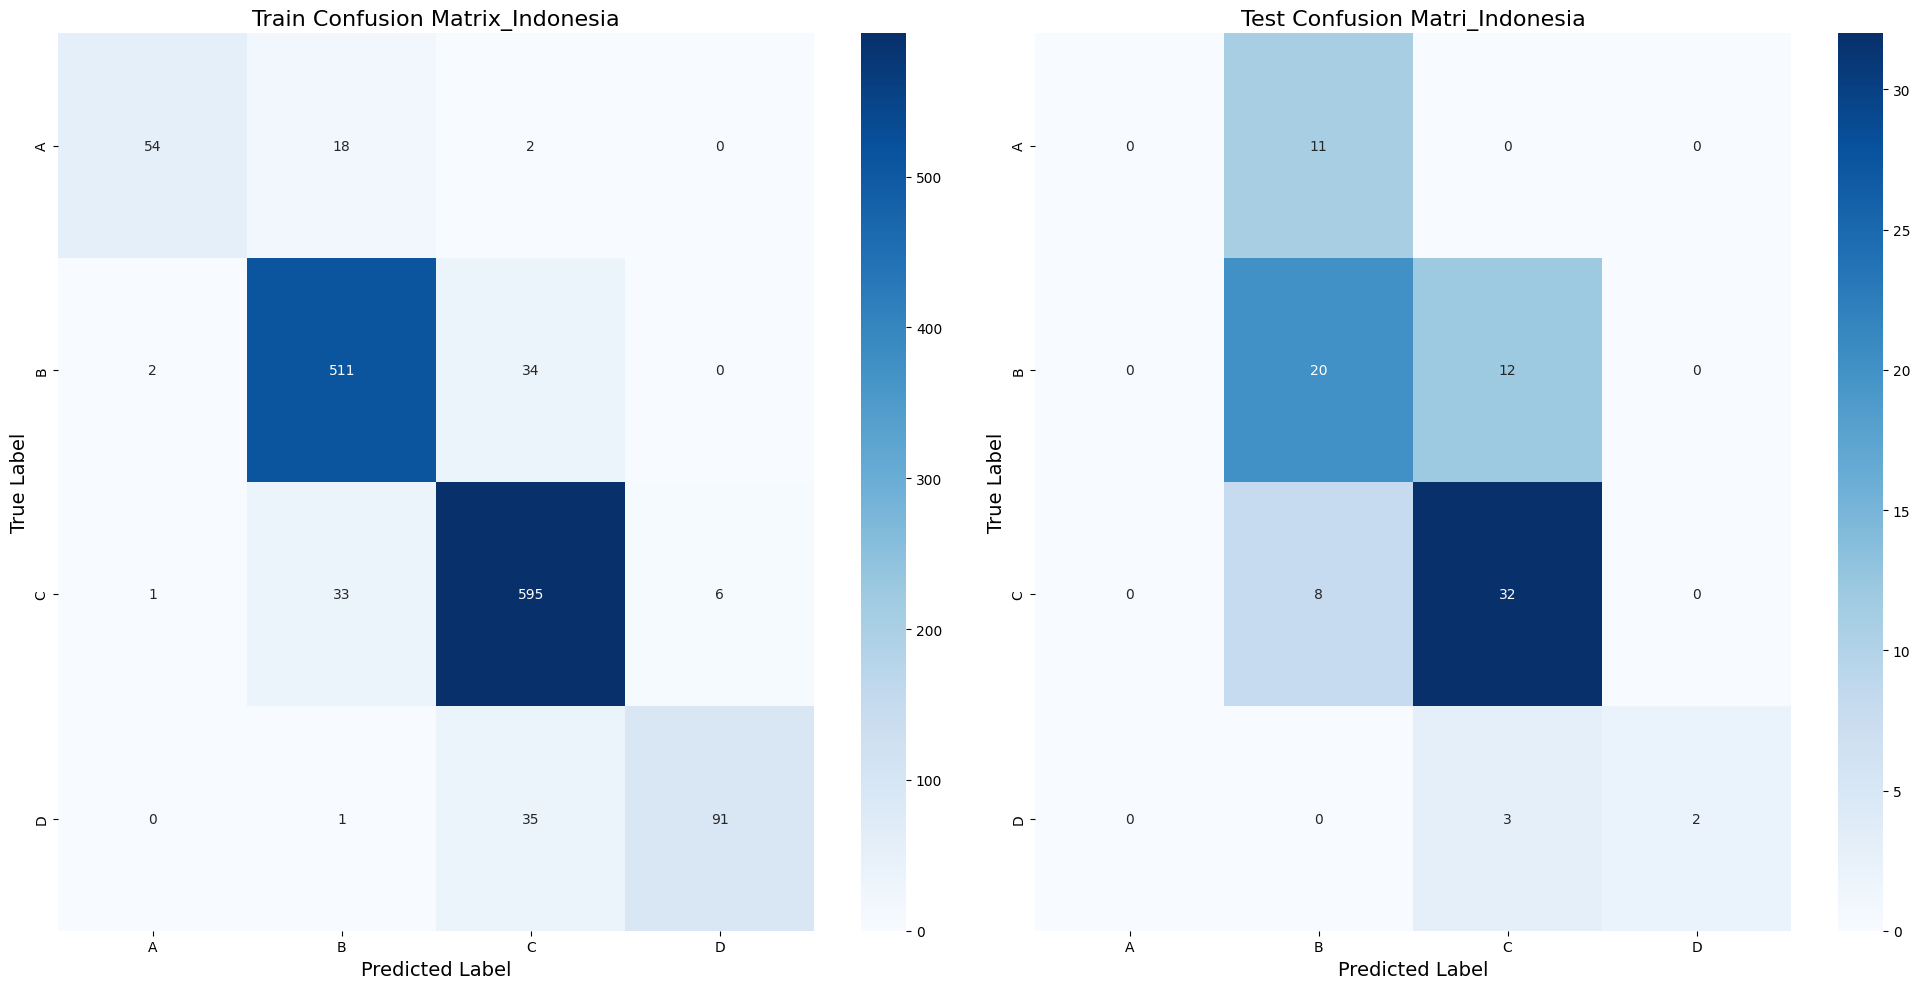

In [36]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Indonesia', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Indonesia', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1383, 41, 4)


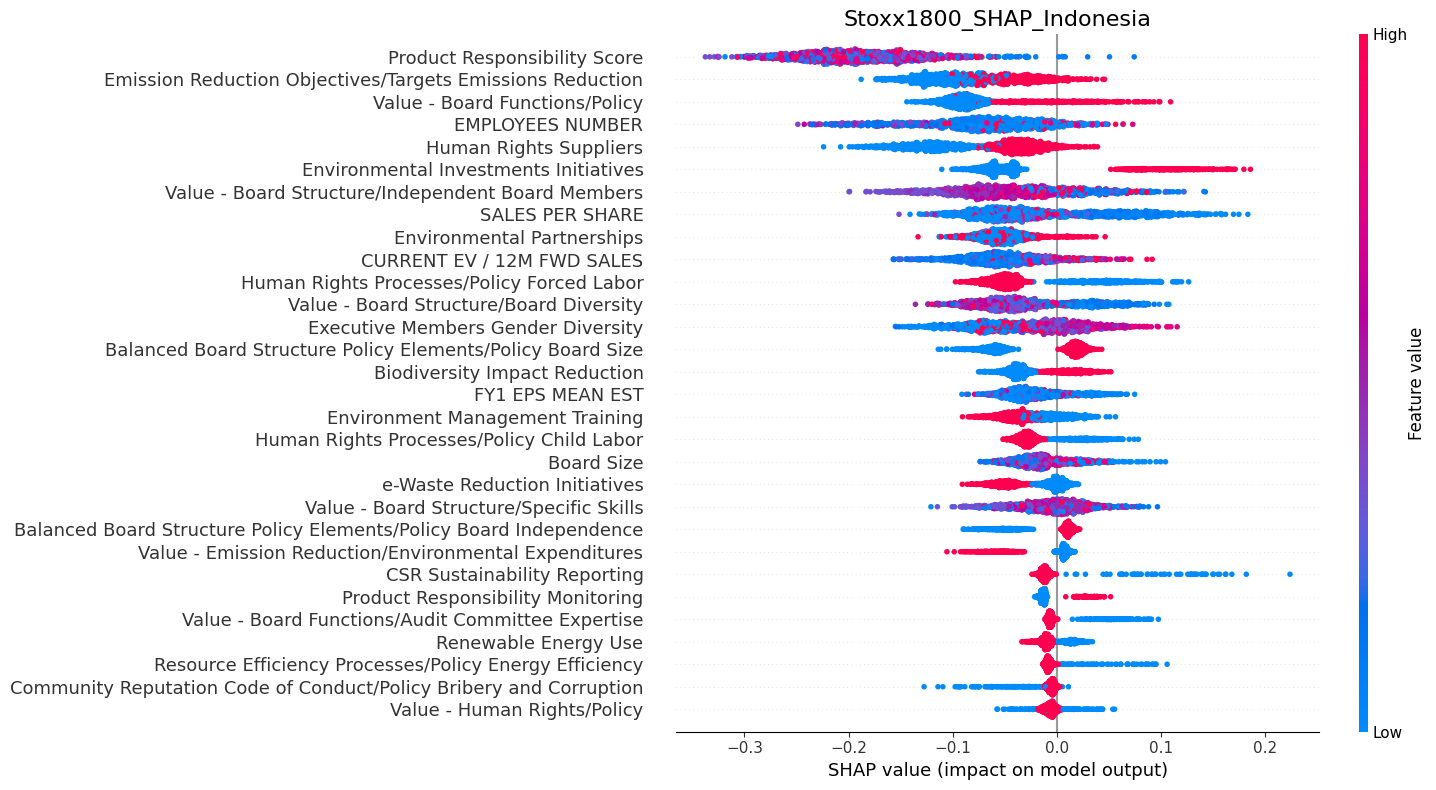

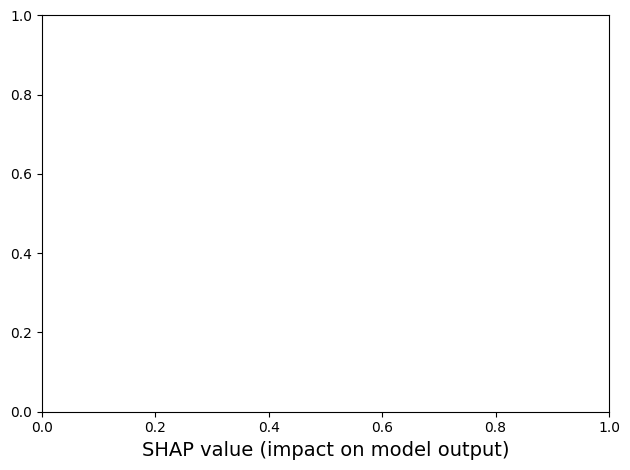

In [ ]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Indonesia", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [95]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 2, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.7830802603036876 F1 Score: 0.7745415370050586 AUC: 0.9368257147535118 prAUC: 0.8155244453836628
Test Results: Accuracy: 0.5681818181818182 F1 Score: 0.5268769152196119 AUC: 0.8302881760216783 prAUC: 0.6043632289122441


In [96]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 1, 'alpha': 3}

Train Results: Accuracy: 0.8329718004338394 F1 Score: 0.8273594096268749 AUC: 0.959770862450927 prAUC: 0.8826366024059838
Test Results: Accuracy: 0.5795454545454546 F1 Score: 0.5383803449514912 AUC: 0.8336913252182282 prAUC: 0.6333710809769111


In [97]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9887128330883843, 'gamma': 3, 'learning_rate': 0.1334380314193006, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 586, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.6424202471887338}

Train Results: Accuracy: 0.7686189443239335 F1 Score: 0.7593487582852969 AUC: 0.9279505108492838 prAUC: 0.7893174019798637
Test Results: Accuracy: 0.5795454545454546 F1 Score: 0.5319794584500467 AUC: 0.8218666773424869 prAUC: 0.5950029917300687


### 1.2.2 预测印度

In [109]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['Indonesia','Vitnam','Singapore','Thailand','Malaysia'])]
test_data = data[data['Market'] == 'India']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Malaysia     361
 Thailand     191
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 India    713
 Name: count, dtype: int64)

In [ ]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['Indonesia','Vitnam','Singapore','Thailand','Malaysia'])]
test_data = data[data['Market'] == 'India']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

In [111]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7955145118733509 F1 Score: 0.7872006958986805 AUC: 0.943633008559497 prAUC: 0.8411524184398751
Test Results: Accuracy: 0.6830294530154277 F1 Score: 0.6724624570786172 AUC: 0.8498518150691874 prAUC: 0.6274043749008896


In [ ]:
# best参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=25,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8878627968337731 F1 Score: 0.8865636988565873 AUC: 0.98641906691406 prAUC: 0.9600378542253627
Test Results: Accuracy: 0.6872370266479664 F1 Score: 0.6791327115412079 AUC: 0.848369077532751 prAUC: 0.6171302608489612


In [113]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.7651715039577837 F1 Score: 0.7554647441912593 AUC: 0.9340048418091185 prAUC: 0.8149677171903655
Test Results: Accuracy: 0.6816269284712483 F1 Score: 0.6701577474443496 AUC: 0.8484881344084837 prAUC: 0.6241727067208385


In [114]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1, 'lambda': 3, 'gamma': 1, 'alpha': 3}

Train Results: Accuracy: 0.8021108179419525 F1 Score: 0.7917035360262407 AUC: 0.9487637421758801 prAUC: 0.8511517081973643
Test Results: Accuracy: 0.6704067321178121 F1 Score: 0.6570888046764032 AUC: 0.847244509062456 prAUC: 0.6271642273687245


In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8343102325093853, 'gamma': 2, 'learning_rate': 0.41047464734119987, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 579, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9056020883680015}

Train Results: Accuracy: 0.8073878627968337 F1 Score: 0.8030363776795778 AUC: 0.9512164397910687 prAUC: 0.865845368566989
Test Results: Accuracy: 0.6746143057503506 F1 Score: 0.6682442081138077 AUC: 0.8439830987020682 prAUC: 0.609421794583074


### 1.2.3 预测新加坡

In [4]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['India','Vitnam','Thailand','Malaysia','Indonesia'])]
test_data = data[data['Market'] == 'Singapore']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Thailand     191
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Singapore    92
 Name: count, dtype: int64)

In [5]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [130]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7875271936185642 F1 Score: 0.7808778820441516 AUC: 0.9421353621785805 prAUC: 0.8363638062070073
Test Results: Accuracy: 0.6521739130434783 F1 Score: 0.638111919599438 AUC: 0.8607751994644793 prAUC: 0.5912389422280575


In [131]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9028281363306744 F1 Score: 0.9013976076999268 AUC: 0.9862534917261568 prAUC: 0.9568581643576276
Test Results: Accuracy: 0.6521739130434783 F1 Score: 0.6444794050343249 AUC: 0.8664936124578099 prAUC: 0.5541586711192558


In [132]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7904278462654097 F1 Score: 0.7834605549671829 AUC: 0.9425414052534534 prAUC: 0.8344015000683844
Test Results: Accuracy: 0.6630434782608695 F1 Score: 0.6371050499594924 AUC: 0.8589102098152612 prAUC: 0.5491001731942259


In [134]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 25, 'learning_rate': 0.05, 'lambda': 3, 'gamma': 3, 'alpha': 1}

Train Results: Accuracy: 0.7679477882523568 F1 Score: 0.7580993875354007 AUC: 0.9263731933971768 prAUC: 0.7918520297762864
Test Results: Accuracy: 0.6630434782608695 F1 Score: 0.6371050499594924 AUC: 0.8597242646339411 prAUC: 0.576761534369336


In [133]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9887128330883843, 'gamma': 3, 'learning_rate': 0.1334380314193006, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 586, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.6424202471887338}

Train Results: Accuracy: 0.7657722987672226 F1 Score: 0.7568108167000037 AUC: 0.9242817960766818 prAUC: 0.7835473904441517
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6647515527950311 AUC: 0.8560732999377179 prAUC: 0.6092172797327051


In [6]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=5,              # L2 正则化
    gamma =3,                   # 添加 gamma 限制分裂
    max_depth=11,                # 降低树的深度
    n_estimators=600,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=1,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=2
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7614213197969543 F1 Score: 0.7509939191981558 AUC: 0.9235913850317004 prAUC: 0.784214926044621
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6616109362947364 AUC: 0.8545183349344163 prAUC: 0.549758528371693


### 1.2.4 预测马来西亚

In [135]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['Indonesia','Vitnam','Singapore','Thailand','India'])]
test_data = data[data['Market'] == 'Malaysia']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Thailand     191
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Malaysia    361
 Name: count, dtype: int64)

In [136]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7875271936185642 F1 Score: 0.7808778820441516 AUC: 0.9421353621785805 prAUC: 0.8363638062070073
Test Results: Accuracy: 0.6521739130434783 F1 Score: 0.638111919599438 AUC: 0.8607751994644793 prAUC: 0.5912389422280575


In [137]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=25,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.896301667875272 F1 Score: 0.894614107109368 AUC: 0.9843450413603942 prAUC: 0.9532115930578122
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6753432494279177 AUC: 0.8696032847606245 prAUC: 0.5760840002257154


In [138]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7904278462654097 F1 Score: 0.7834605549671829 AUC: 0.9425414052534534 prAUC: 0.8344015000683844
Test Results: Accuracy: 0.6630434782608695 F1 Score: 0.6371050499594924 AUC: 0.8589102098152612 prAUC: 0.5491001731942259


In [139]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 25, 'learning_rate': 0.05, 'lambda': 3, 'gamma': 3, 'alpha': 1}

Train Results: Accuracy: 0.7679477882523568 F1 Score: 0.7580993875354007 AUC: 0.9263731933971768 prAUC: 0.7918520297762864
Test Results: Accuracy: 0.6630434782608695 F1 Score: 0.6371050499594924 AUC: 0.8597242646339411 prAUC: 0.576761534369336


In [140]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9887128330883843, 'gamma': 3, 'learning_rate': 0.1334380314193006, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 586, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.6424202471887338}

Train Results: Accuracy: 0.7657722987672226 F1 Score: 0.7568108167000037 AUC: 0.9242817960766818 prAUC: 0.7835473904441517
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6647515527950311 AUC: 0.8560732999377179 prAUC: 0.6092172797327051


In [141]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=5,              # L2 正则化
    gamma=3,                   # 添加 gamma 限制分裂
    max_depth=11,               # 降低树的深度
    n_estimators=586,          # 树的数量
    learning_rate=0.13,        # 降低学习率
    subsample=0.642,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsample_bylevel=0.98,
    min_child_weight=2,
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7585206671501088 F1 Score: 0.7488366693037148 AUC: 0.922659368171741 prAUC: 0.7800481829192261
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6509082386030706 AUC: 0.8497552687583199 prAUC: 0.5140216320134633


### 1.2.5 预测泰国

In [38]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['India','Vitnam','Indonesia','Singapore','Malaysia'])]
test_data = data[data['Market'] == 'Thailand']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Thailand    191
 Name: count, dtype: int64)

In [39]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [147]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.796875 F1 Score: 0.7898478032951479 AUC: 0.9430202553059208 prAUC: 0.8415434752017084
Test Results: Accuracy: 0.7120418848167539 F1 Score: 0.7072765299732316 AUC: 0.8692746117008308 prAUC: 0.701909238626364


In [148]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9 F1 Score: 0.8983777735108381 AUC: 0.9862919605959302 prAUC: 0.9570534138066482
Test Results: Accuracy: 0.6492146596858639 F1 Score: 0.6514588703694809 AUC: 0.8452501318872887 prAUC: 0.6158747985963822


In [149]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.79765625 F1 Score: 0.7891228956978866 AUC: 0.945582121642966 prAUC: 0.8468121323949049
Test Results: Accuracy: 0.7225130890052356 F1 Score: 0.7113444217614645 AUC: 0.8737272392221579 prAUC: 0.7012393064997231


In [40]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.79765625 F1 Score: 0.7891228956978866 AUC: 0.945582121642966 prAUC: 0.8468121323949049
Test Results: Accuracy: 0.7225130890052356 F1 Score: 0.7113444217614645 AUC: 0.8737272392221579 prAUC: 0.7012393064997231


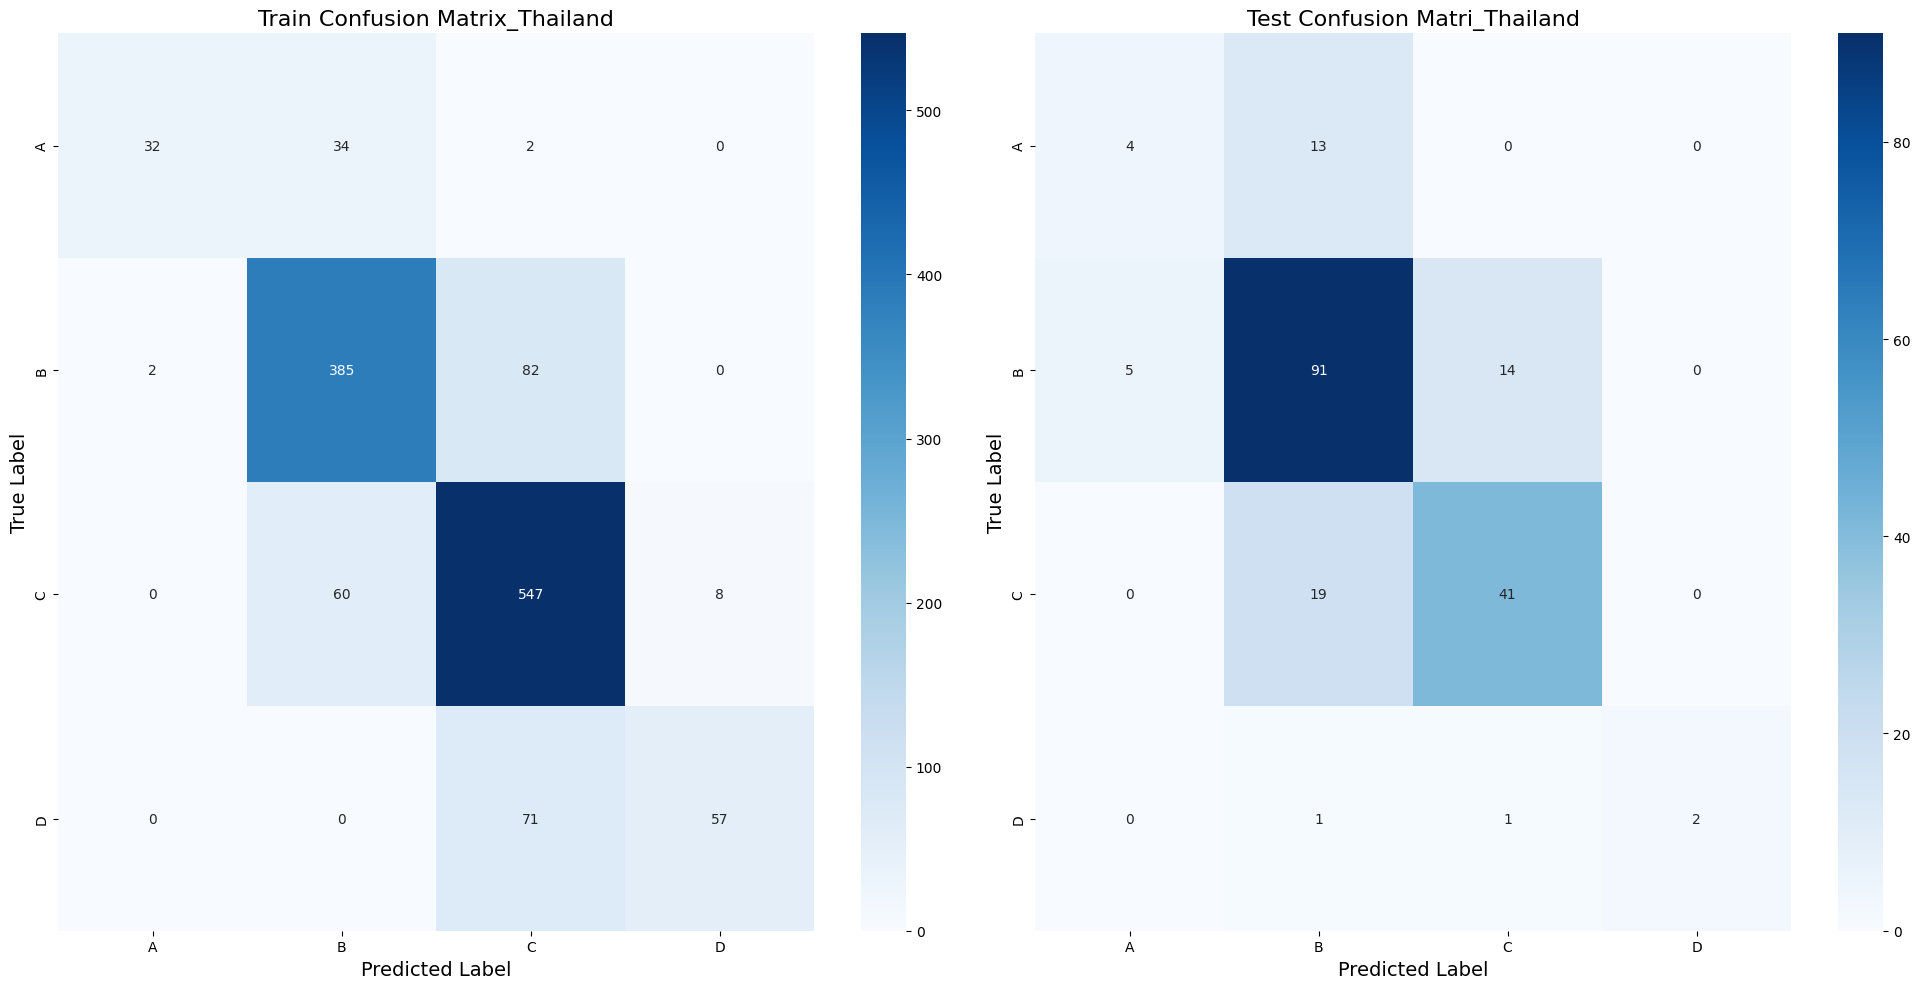

In [41]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Thailand', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Thailand', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1280, 41, 4)


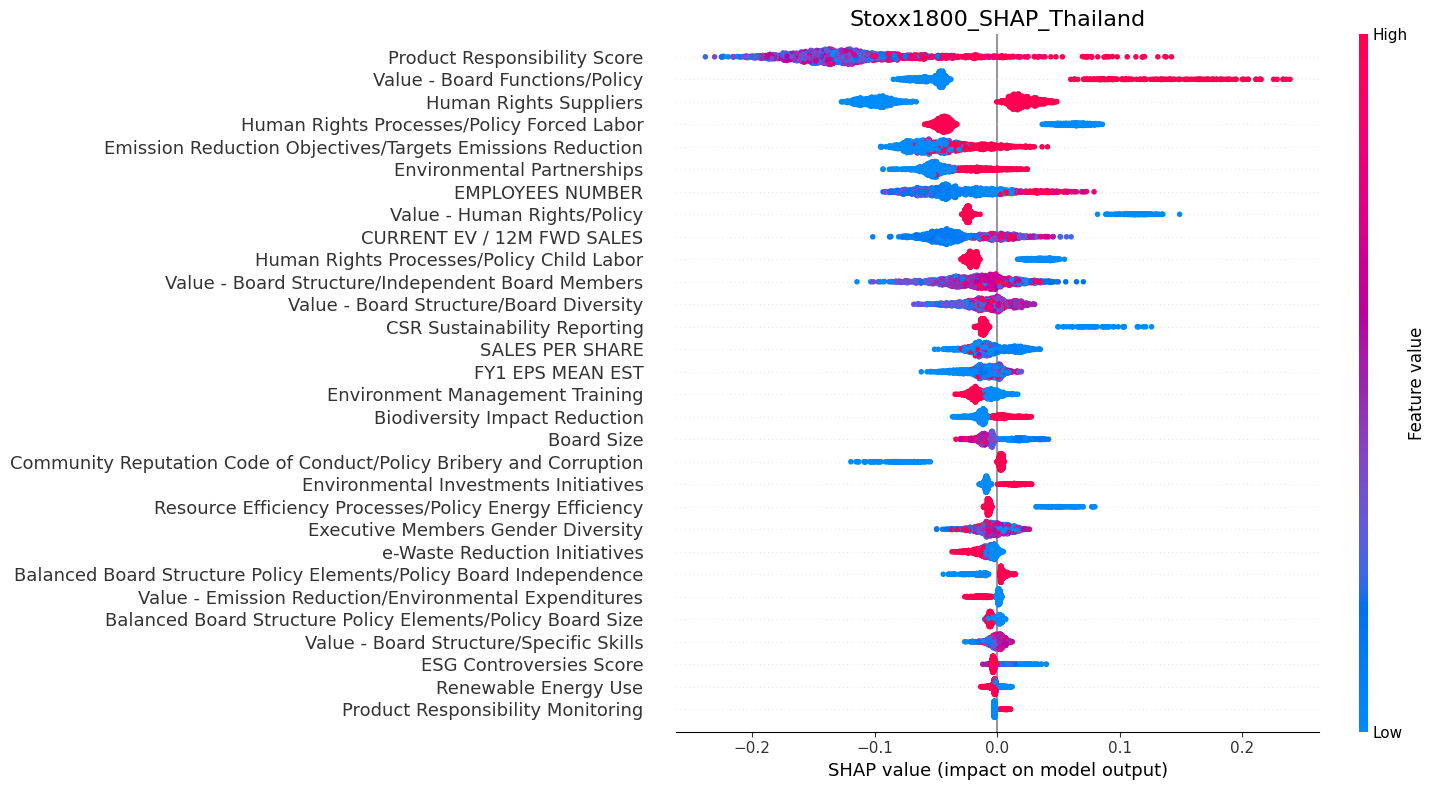

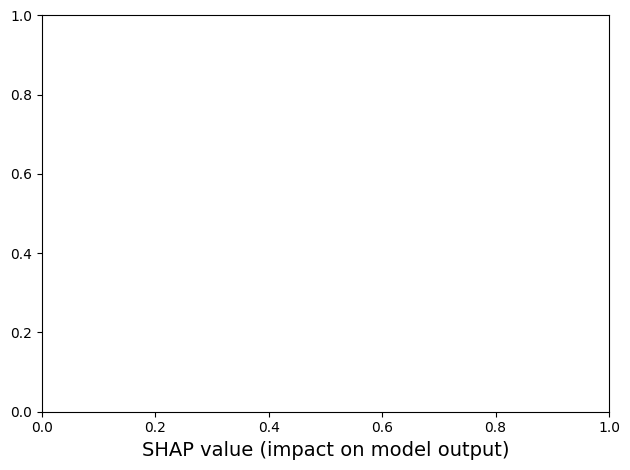

In [42]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Thailand", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [150]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.01, 'lambda': 1, 'gamma': 3, 'alpha': 2}

Train Results: Accuracy: 0.74765625 F1 Score: 0.7331896215232544 AUC: 0.9136850025948349 prAUC: 0.765395786684767
Test Results: Accuracy: 0.7277486910994765 F1 Score: 0.7106487386700351 AUC: 0.8707005575855867 prAUC: 0.6891077425255412


In [151]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8343102325093853, 'gamma': 2, 'learning_rate': 0.41047464734119987, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 579, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9056020883680015}

Train Results: Accuracy: 0.80859375 F1 Score: 0.802756280754703 AUC: 0.9508111673869648 prAUC: 0.8644118175939912
Test Results: Accuracy: 0.7120418848167539 F1 Score: 0.7076458392995698 AUC: 0.8657189945657241 prAUC: 0.6722633603754852


### 1.2.6 预测越南

In [2]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')

train_data = data[data['Market'].isin(['India','Indonesia','Singapore','Malaysia', 'Thailand'])]
test_data = data[data['Market'] == 'Vitnam']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Thailand     191
 Singapore     92
 Indonesia     88
 Name: count, dtype: int64,
 Market
 Vitnam    26
 Name: count, dtype: int64)

In [3]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [6]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7951557093425605 F1 Score: 0.7871857259855864
Test Results: Accuracy: 0.7307692307692307 F1 Score: 0.7333333333333333


In [4]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
  
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.9024221453287197 F1 Score: 0.90061905207813
Test Results: Accuracy: 0.8461538461538461 F1 Score: 0.8469930069930071


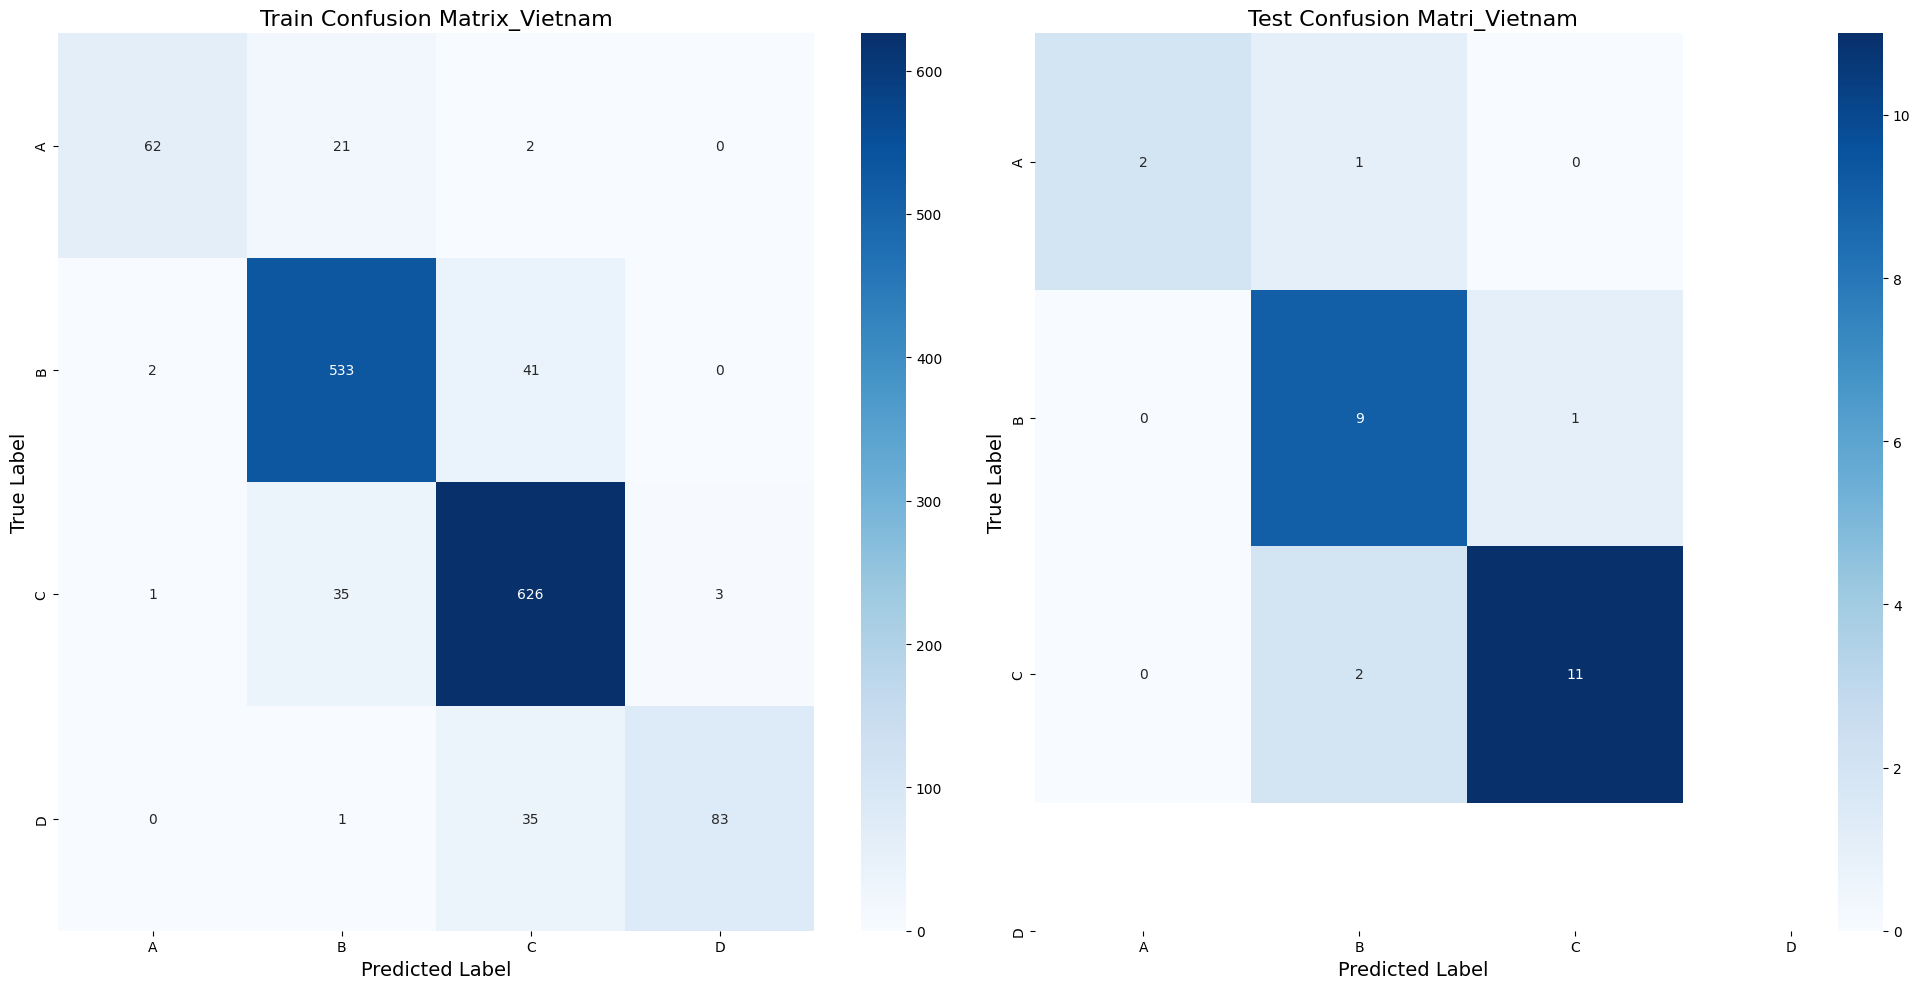

In [23]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Vietnam', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Vietnam', fontsize=16)

plt.tight_layout()
plt.show()


In [7]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1445, 41, 4)


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1445, 41, 4)


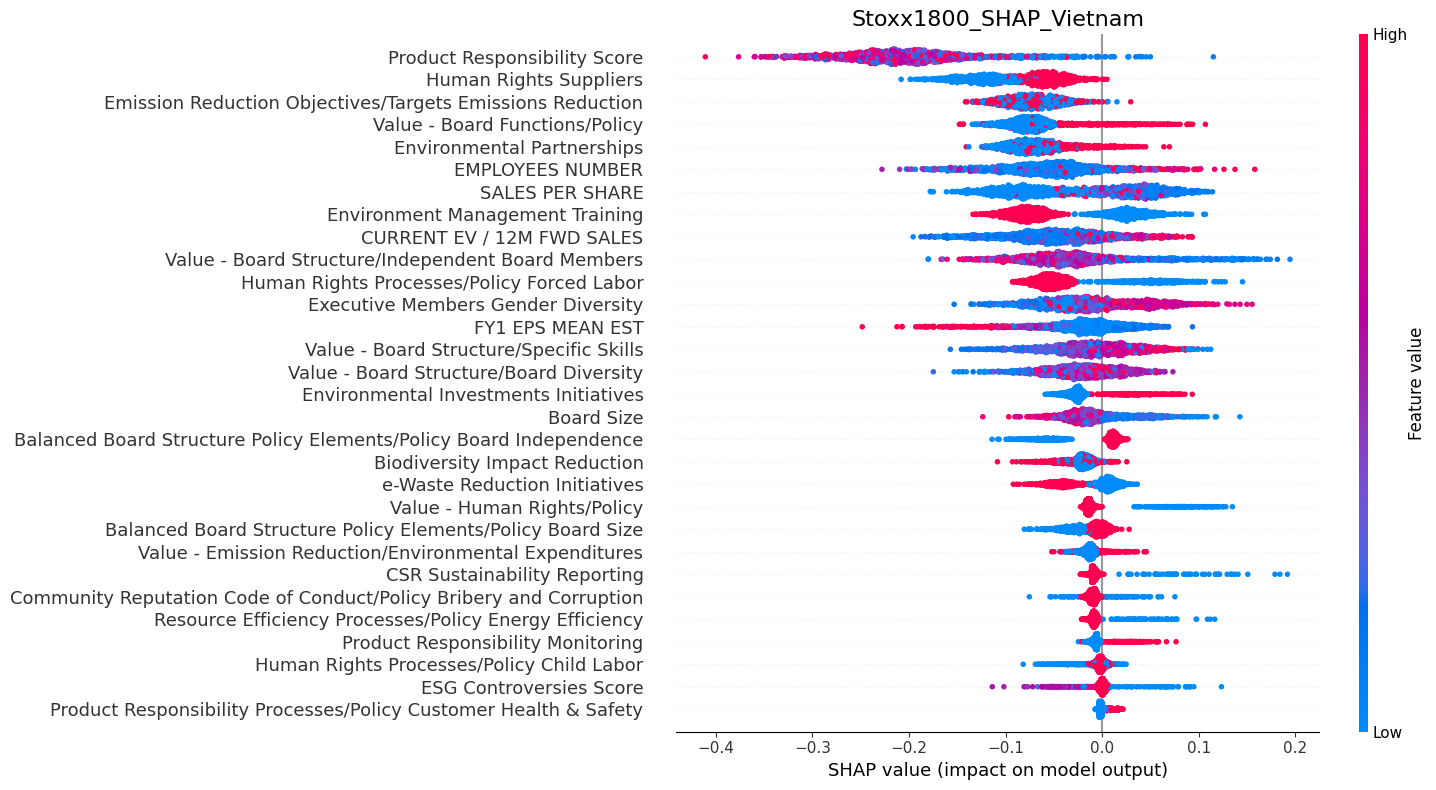

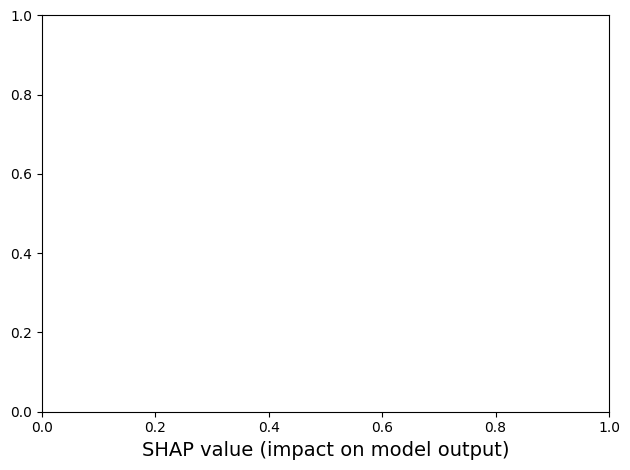

In [13]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Vietnam", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [ ]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])
